# RMSLE
La métrica de evaluación para esta competición es el Error Logarítmico Cuadrático Medio (RMSLE por sus siglas en inglés).

<br>

<center><img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*39eUocUvQjA9KO2eiiSkqA.jpeg" style="width:30%;height:10%;"></center>

el RMSLE es una medida que evalúa la diferencia entre los valores predichos y reales del objetivo, tomando en cuenta el logaritmo de estas diferencias.

# STORE SALES -TIMES SERIES FORECASTING

Este concurso trata sobre la previsión de series temporales para las ventas en tienda. Los datos proceden de una empresa ecuatoriana conocida como Corporación Favorita y es un gran minorista de comestibles. Además, la empresa opera en otros países de Sudamérica.

Este Notebook se centra en:
- Analisis Exploratorio

Hay **54 tiendas** y **33 familias de productos** en los datos. La serie temporal comienza el **2013-01-01** y termina el **2017-08-31**. Sin embargo, Kaggle nos da dos datos divididos como entrenamiento y prueba. Las fechas en los datos de prueba son para los **15 días** después de la última fecha en los datos de entrenamiento. El rango de fechas en los datos de prueba será muy importante mientras definimos una estrategia de validación cruzada y creamos nuevas características.

***Nuestra misión principal en este concurso es predecir las ventas de cada familia de productos y combinación de tiendas.***

Hay 6 datos que estudiaremos en ellos paso a paso.
1. *TRAIN*
2. *TEST*
3. *STORES*
4. *TRANSACTIONS*
5. *HOLIDAYS AND EVENTS*
6. *OIL PRICE*

**<code>TRAIN</code>** contienen series temporales de la combinación de tiendas y familias de productos. La columna de ventas indica las ventas totales de una familia de productos en una tienda concreta en una fecha determinada. Los valores fraccionarios son posibles, ya que los productos pueden venderse en unidades fraccionarias (1,5 kg de queso, por ejemplo, frente a 1 bolsa de patatas fritas).La columna en promoción da el número total de artículos de una familia de productos que estaban en promoción en una tienda en una fecha determinada.

**<code>STORES</code>** da alguna información sobre las tiendas como ciudad, estado, tipo, cluster.

**<code>TRANSACTIONS</code>** están muy correlacionados con la columna de ventas del tren. Se pueden entender los patrones de ventas de las tiendas.

**<code>HOLIDAYS AND EVENTS</code>** es un metadato. Estos datos son muy valiosos para comprender las ventas pasadas, la tendencia y los componentes de estacionalidad. Sin embargo, es necesario organizarlos. Va a encontrar una manipulación exhaustiva de estos datos. Esta parte será uno de los capítulos más importantes de este cuaderno.

**<code>OIL PRICE</code>** es otro dato que nos ayudará. Ecuador es un país dependiente del petróleo y su salud económica es muy vulnerable a las fluctuaciones del precio del petróleo. Por eso, nos ayudará a entender qué familias de productos se ven afectadas de forma positiva o negativa por el precio del petróleo.

#### Cuando consulte la descripción de los datos, verá "Notas adicionales". Estas notas pueden ser significativas para captar algunos patrones o anomalías. Se las comparto para que las recuerde.
- Los salarios en el sector público se pagan quincenalmente el día 15 y el último día del mes. Las ventas en los supermercados podrían verse afectadas.
- Un terremoto de magnitud 7,8 sacudió Ecuador el 16 de abril de 2016. La gente se movilizó en labores de socorro donando agua y otros productos de primera necesidad, lo que afectó enormemente a las ventas de los supermercados durante varias semanas después del terremoto.

# BIBLIOTECAS
---

In [68]:
import plotly.express as px
from scipy.stats import f_oneway
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import calendar
import gc

# CARGA DE DATOS
---

In [69]:
train = pd.read_csv('data/train.csv')
holidays=pd.read_csv('data/holidays_events.csv')
oil=pd.read_csv('data/oil.csv')
stores=pd.read_csv('data/stores.csv')
transactions=pd.read_csv('data/transactions.csv')
test=pd.read_csv('data/test.csv')

# TRAIN
---
---

## Feature Engineering
---

### New Features
* Combinaremos el DF de Train y Test
* Create date featues (e.g. year/month/weekday etc)
* Creamos una columna de día del mes que podría ser información relevante de cuantos días desde la fecha de cobro de sueldos aumentan las ventas
* create lag sales features
* Creamos una columna qe me diga si hay artículos en promoción o no

Primeramente combinaremos ambos DFs, Train y Test ya que haremos la tarea de ingienería de variables para ambos DataFrames

In [70]:
# add dummy sales column to test so we can concat
test['sales'] = 0
train_test = pd.concat([train,test])

In [71]:
train_test['date'] = train_test['date'].astype('datetime64[ns]')

In [72]:
#Aquí hacemos las operaciones de a partir de la columna "date", crear columnas nuevas que puedan captar tendencias relacionadas con el tiempo
train_test['date'] = train_test['date'].astype('datetime64[ns]')
train_test['year'] = train_test['date'].dt.year
train_test['dayofyear'] = train_test['date'].dt.dayofyear
train_test['quarter'] = train_test['date'].dt.quarter
train_test['weekofyear'] = train_test['date'].dt.weekofyear
train_test['weekday'] = train_test['date'].dt.dayofweek
train_test['month'] = train_test['date'].dt.month
train_test['day'] = train_test['date'].dt.day
train_test['day_name']= train_test["date"].apply(lambda x: x.strftime('%A'))

C:\Users\Javier\AppData\Local\Temp\ipykernel_20636\3141118483.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_test['weekofyear'] = train_test['date'].dt.weekofyear


### LAGS

In [73]:
# use the below lags
train_lags = [16,17,18,21,28,35,42]

In [74]:
store_nbrs = train['store_nbr'].unique()
families = train['family'].unique()

In [75]:
# create lag features
for store in store_nbrs:

    for family in families:
    
        store_family_index = (train_test['store_nbr'] == store) & (train_test['family'] == family)
        
        
        for lag in train_lags:
    
            train_test.loc[store_family_index,f'sales-{lag}'] = train_test.loc[store_family_index,'sales'].shift(lag)

### Quitamos columnas creadas para visualizacion
* Day_name: Esta columna que hemos utilizado para ver graficos, no aportara ningun valor en la parte de Machine Learning
* Promote_y_n: teniendo la columna con el numero de promociones, ya es suficiente

In [76]:
train_test.drop(columns=['day_name'],inplace=True)

# TRANSACTIONS_DF
---
---

## Feature Engineering
---

### New Features:
* Ampliamos el DF para que contenga fechas de todo el periodo Train + Test
* Agregamos columnas de año y mes para ver autocorrelacion mensual
* Añadimos lags al dataset que utilizaremos, como hemos visto no disponemos de las transacciones del periodo test, por lo que añadimos lags

In [77]:
transactions['date'] = transactions['date'].astype('datetime64[ns]')

In [78]:
date_dummy = pd.DataFrame(pd.date_range(start=train['date'].min(), end=test['date'].max()), columns=['date'])
store_nbr_dummy = pd.DataFrame(stores, columns=['store_nbr'])

transactions_dummy = date_dummy.merge(store_nbr_dummy, how='cross')

transactions = transactions_dummy.merge(transactions, how='left', left_on=['date','store_nbr'], right_on=['date','store_nbr']).fillna(0)

### Lags

In [79]:
transaction_lags = [18,20,21,22,24,25,26,28,70,140,210,365]


for store in store_nbrs:

    store_family_index = transactions['store_nbr'] == store

    for lag in transaction_lags:

        transactions.loc[store_family_index,f'transactions-{lag}'] = transactions.loc[store_family_index,'transactions'].shift(lag)

### Eliminamos columna "Transactoins"
* La variable que vamos apoder usar en test es las ventas de x dias anteriores, la mejor medida que tendremos es la de 18 dias antes

In [80]:
transactions = transactions.drop(['transactions'], axis=1)
transactions = transactions.dropna()

# STORES
---
---

### New Features
* We will one-hot-encode the catagorical variables, but leaving the orignal columns for merging the data (will be dropped later on)

### One Hot Encoding

In [81]:
store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

stores_encoded_array = store_encoder.fit_transform(stores[['city','state','type','cluster']])

stores = pd.concat([stores,stores_encoded_array], axis=1)

#stores = stores.drop(['type'], axis=1)

# OIL_df
---
---
-  Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

## Featuring Engineering
---

### New Features
* Need to fill na columns
* we're missing some dates from the dataset (e.g. 5th Jan 2013) so we need to create the correct data range and work from that to fill na values
* use a 5 day moving average to impute null values


In [82]:
oil['date'] = oil['date'].astype('datetime64[ns]')

In [83]:
train_start = train['date'].min()
train_end = train['date'].max()
test_start = test['date'].min()
test_end = test['date'].max()

date_range = pd.DataFrame(pd.date_range(start=train_start, end=test_end), columns=['date'])

In [84]:
oil = date_range.merge(oil, how='left', left_on=['date'], right_on=['date'])

In [85]:
# fill na columns with 5 day rolling average centred on the point
oil_na_mask = oil['dcoilwtico'].isna()

oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].rolling(5, center=True, min_periods=1).mean())

# 6. Holidays and Events

What a mess! Probably, you are confused due to the holidays and events data. It contains a lot of information inside but, don't worry. You just need to take a breathe and think! It is a meta-data so you have to split it logically and make the data useful.

What are our problems?
- Some national holidays have been transferred.
- There might be a few holidays in one day. When we merged all of data, number of rows might increase. We don't want duplicates.
- What is the scope of holidays? It can be regional or national or local. You need to split them by the scope.
- Work day issue
- Some specific events
- Creating new features etc.


End of the section, they won't be a problem anymore!


Transferred Holidays

El problema que tenemos aqui es que tenemos un dataset que modifica para su correcta implementacion para el entrenamiento.

A)Tenemos festivos que han sido transferidos lo que sería tipo Holiday y Transferred=True y ademas la propia fecha efectiva en la cual ha sido transferido, lo que es Type=Transfer.
Tiene sentido que ambas logicas sean iguales en filas, y el objetivo es quedarnos unicamente con la fecha que fue efectiva el Holiday, es decir, la segunda relación lógica, Type=Transfer, por lo que queremos quedarnos unicamente con la fecha efectiva en la que resulto un dia de "holiday" real.
Por ello vamos a hacer dos DFs y posterior limpieza

tr1 son los dias de vacaciones originales que han sido transferidos

``tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)``

tr2 es la fecha final efectiva de vacaciones

``tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)``

tr es la concatenacion de ambos DFs y no es mal que el agregado horizontal de ambos

Habiendo hecho un reset_index los ordenamos por su indice (gracias por el orden)

``tr = pd.concat([tr1,tr2], axis = 1)``

![image.png](attachment:image.png)

Nos quedamos con las columnas de interes que integraremos posteriormente

``tr = tr.iloc[:, [5,1,2,3,4]]``

Para finalizar este primer ajuste vamos a realizar tan solo una agregacion vertical de:
Todas los festivos que no hayan sido transferidos, es decir, fechas efectivas de Vacaciones, además eliminamos la columana "Transferred"

``holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)``

Hacemos la agregacion vertical de esto con la limpieza previa:

``holidays = holidays.append(tr).reset_index(drop = True)``

#### Additional Holidays
Lo que vamos a hacer es limpiar la informacion y colocarlo dentro de la categoria Type=Holiday

1) ``holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')``

    Eliminamos los caracteres como "-" , "+" y además con una expresion regular ('\d+',"") eliminamos todos los digitos al final del string

2) ``holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])``

    sustituimos todos los campos con Type=Addtional por Holiday

#### Bridge Holidays
Vamos a limpiar igualmente la descripcion y modificar como en el caso anterior, el type=Brdige por Holiday

1) ``holidays["description"] = holidays["description"].str.replace("Puente ", "")``

    Borramos "Puente " de la descripcion de cada fila para que aparezca unicamente la info de la festividad

2) ``holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])``

    Cambiamos el tipo Bridge por Holiday

#### Work Day Holidays
``work_day = holidays[holidays.type == "Work Day"] ``

``holidays = holidays[holidays.type != "Work Day"]``
Los dias de trabajo no los queremos

In [86]:
#holidays = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")
holidays["date"] = pd.to_datetime(holidays.date)


# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)


# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  


#Split

#Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()


# Train + Test
train_test = pd.merge(train_test, stores)
train_test["store_nbr"] = train_test["store_nbr"].astype("int8")


# National Holidays & Events
train_test = pd.merge(train_test, national, how = "left")

#Regional
train_test= pd.merge(train_test, regional, how = "left", on = ["date", "state"])
# # Local
train_test = pd.merge(train_test, local, how = "left", on = ["date", "city"])
# Work Day: It will be removed when real work day colum created
train_test = pd.merge(train_test,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

train_test = pd.merge(train_test, events, how = "left")
train_test[events_cat] = train_test[events_cat].fillna(0)

# New features
train_test["holiday_national_binary"] = np.where(train_test.holiday_national.notnull(), 1, 0)
train_test["holiday_local_binary"] = np.where(train_test.holiday_local.notnull(), 1, 0)
train_test["holiday_regional_binary"] = np.where(train_test.holiday_regional.notnull(), 1, 0)

# 
train_test["national_independence"] = np.where(train_test.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
train_test["local_cantonizacio"] = np.where(train_test.holiday_local.str.contains("Cantonizacio"), 1, 0)
train_test["local_fundacion"] = np.where(train_test.holiday_local.str.contains("Fundacion"), 1, 0)
train_test["local_independencia"] = np.where(train_test.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(train_test[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
train_test = pd.concat([train_test.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = train_test.columns[train_test.columns.str.startswith("events")].tolist() + train_test.columns[train_test.columns.str.startswith("holiday")].tolist() + train_test.columns[train_test.columns.str.startswith("national")].tolist()+ train_test.columns[train_test.columns.str.startswith("local")].tolist()
train_test[he_cols] = train_test[he_cols].astype("int8")

train_test[["family", "city", "state", "type"]] = train_test[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

train_test.head(10)

C:\Users\Javier\AppData\Local\Temp\ipykernel_20636\3554847841.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holidays = holidays.append(tr).reset_index(drop = True)
C:\Users\Javier\AppData\Local\Temp\ipykernel_20636\3554847841.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
C:\Users\Javier\AppData\Local\Temp\ipykernel_20636\3554847841.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')


,id,date,store_nbr,family,sales,onpromotion,year,dayofyear,quarter,weekofyear,weekday,month,day,sales-16,sales-17,sales-18,sales-21,sales-28,sales-35,sales-42,city,state,type,cluster,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Azuay,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,type_A,type_B,type_C,type_D,type_E,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,IsWorkDay,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0

**Let's apply an AB test to Events and Holidays features. Are they statistically significant? Also it can be a good way for first feature selection.**

- *H0: The sales are equal* **(M1 = M2)**
- *H1: The sales are not equal* **(M1 != M2)**

In [87]:
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    
    # Print Hypothesis
    # print("# A/B Testing Hypothesis")
    # print("H0: A == B")
    # print("H1: A != B", "\n")
    
    return temp
    
# Apply A/B Testing
he_cols = train_test.columns[train_test.columns.str.startswith("events")].tolist() + train_test.columns[train_test.columns.str.startswith("holiday")].tolist() + train_test.columns[train_test.columns.str.startswith("national")].tolist()+ train_test.columns[train_test.columns.str.startswith("local")].tolist()
ab = []
for i in he_cols:
    ab.append(AB_Test(dataframe=train_test[train_test.sales.notnull()], group = i, target = "sales"))
ab = pd.concat(ab)
ab

c:\Users\Javier\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Javier\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Javier\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Javier\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Javier\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWa

,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,events_Black_Friday,Non-Parametric,Reject H0,5.740308e-24,A/B groups are not similar!,363.360708,354.392622,17.000000,10.0
0,events_Cyber_Monday,Non-Parametric,Reject H0,2.150031e-31,A/B groups are not similar!,436.220250,354.263819,17.000000,10.0
0,events_Dia_de_la_Madre,Non-Parametric,Reject H0,9.085187e-03,A/B groups are not similar!,348.536505,354.425769,9.000000,10.0
0,events_Futbol,Non-Parametric,Reject H0,7.094536e-79,A/B groups are not similar!,310.965144,354.769187,5.000000,10.0
0,events_Terremoto_Manabi,Non-Parametric,Reject H0,0.000000e+00,A/B groups are not similar!,494.904072,351.798883,23.000000,10.0
0,holiday_national_binary,Non-Parametric,Reject H0,1.935148e-10,A/B groups are not similar!,424.447188,351.040370,11.000000,10.0
0,holiday_local_binary,Non-Parametric,Reject H0,2.329166e-12,A/B groups are not similar!,424.755295,354.129947,14.000000,10.0
0,holiday_regional_binary,Non-Parametric,Reject H0,1.430984e-03,A/B groups are not similar!,229.725442,354.450566,6.000000,10.0
0,holiday_national_Batalla_de_Pichincha,Non-Parametric,Fail to Reject H0,1.317803e-01,A/B groups are similar!,391.726745,354.298364,12.000000,10.0
0,holiday_national_Carnaval,Non-Parametric,Fail to Reject H0,3.663501e-01,A/B groups are similar!,332.882573,354.535820,10.000000,10.0


In [88]:
fails=ab[ab["AB Hypothesis"]=="Fail to Reject H0"]["Feature"].to_list()
fails

['holiday_national_Batalla_de_Pichincha',
 'holiday_national_Carnaval',
 'holiday_regional_Provincializacion_Santa_Elena',
 'holiday_regional_Provincializacion_de_Imbabura',
 'holiday_regional_Provincializacion_de_Santo_Domingo',
 'holiday_local_Cantonizacion_de_El_Carmen',
 'holiday_local_Cantonizacion_de_Guaranda',
 'holiday_local_Cantonizacion_de_Latacunga',
 'holiday_local_Cantonizacion_de_Quevedo',
 'holiday_local_Cantonizacion_de_Riobamba',
 'holiday_local_Cantonizacion_de_Salinas',
 'holiday_local_Fundacion_de_Esmeraldas',
 'holiday_local_Fundacion_de_Guayaquil',
 'holiday_local_Fundacion_de_Ibarra',
 'holiday_local_Fundacion_de_Machala',
 'holiday_local_Independencia_de_Guaranda',
 'holiday_local_Independencia_de_Latacunga']

In [89]:
# columns_to_keep = [col for col in train_test.columns if col not in fails]

# train_test = train_test[columns_to_keep]

In [90]:
# categorical_columns = train_test.select_dtypes(include=['category']).columns
# print(train_test[categorical_columns])

# Zero Forecasting

Some stores don't sell some product families. In the following code, you can see which products aren't sold in which stores. It isn't difficult to forecast them next 15 days. Their forecasts must be 0 next 15 days.

I will remove them from the data and create a new data frame for product families which never sell. Then, when we are at submission part, I will combine that data frame with our predictions.

In [91]:
c = train_test.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


In [92]:
exe=pd.merge(c,test,on=['store_nbr','family'])
id_zero=exe["id"]

Our first forecasting is done! You don't need the machine learning or deep learning or another things for these time series because we had some simple time series.

<center><img src="https://preview.redd.it/nc5ua4x8lfg31.png?auto=webp&s=620a441877c6e497f7bc9a4b6c39548bb00aef0a" style="width:50%;height:10%;"></center>


# ENTRENAMIENTO & SUMISION

## Concatenate all DataFrames for Training


In [93]:
print(train_test.shape)
print(transactions.shape)
print(stores.shape)
print(oil.shape)

(3029400, 135)
(72306, 14)
(54, 65)
(1704, 2)


In [94]:
#  merge train, oil & stores
print(train_test.shape)
all_concat = train_test.merge(oil, how='left', on='date')
print(all_concat.shape)
all_concat = all_concat.merge(stores, left_on=['store_nbr'], right_on=['store_nbr'], suffixes = ['_store', '_holiday'])
print(all_concat.shape)
all_concat = all_concat.merge(transactions, left_on=['date','store_nbr'], right_on=['date','store_nbr'])
# print(train_test.shape) # should drop due to removing date that can't have lags

(3029400, 135)


(3029400, 136)
(3029400, 200)


## Final Adjustments
* remove date from disaster period since data isn't representative (2016-04-16)
* fill na data (from holiday columns) with 0 where no merge was found
* set index to date column

In [95]:
## look at total sales by day 3 months before and after period to see when level were back to normal
period_mask = (all_concat['date'].dt.date >= datetime.date(2016,1,15)) & (all_concat['date'].dt.date < datetime.date(2016,12,15))

all_concat_disaster = all_concat[period_mask]

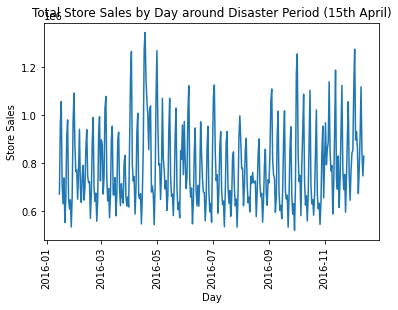

In [96]:
## volumes seem to normalise within approx 1 month - remove data from that period
disater_period_sales = all_concat_disaster.groupby('date')['sales'].sum()

plt.plot(disater_period_sales)
plt.ylabel('Store Sales')
plt.xlabel('Day')
plt.xticks(rotation=90)
plt.title('Total Store Sales by Day around Disaster Period (15th April)')
plt.show()

* Hay una epoca de 4 semanas desde el terremoto en 16 de Abril de 2016 que no es representativo - lo borramos

Para ello hacemos un filtro en donde hacemos que sea menor de la fecha del terremoto y mayor a la misma fecha + 4 semanas

In [97]:
period_mask = (
    (all_concat['date'].dt.date < datetime.date(2016, 4, 16)) |
    (all_concat['date'].dt.date >= datetime.date(2016, 4, 16) + datetime.timedelta(weeks=4))
)

all_concat = all_concat[period_mask]

In [98]:
categorical_columns = all_concat.select_dtypes(include=['category']).columns
print(all_concat[categorical_columns])

                             family city_store state_store type_store
0                        AUTOMOTIVE      Quito   Pichincha          D
1                         BABY CARE      Quito   Pichincha          D
2                            BEAUTY      Quito   Pichincha          D
3                         BEVERAGES      Quito   Pichincha          D
4                             BOOKS      Quito   Pichincha          D
...                             ...        ...         ...        ...
2380747                     POULTRY      Quito   Pichincha          B
2380748              PREPARED FOODS      Quito   Pichincha          B
2380749                     PRODUCE      Quito   Pichincha          B
2380750  SCHOOL AND OFFICE SUPPLIES      Quito   Pichincha          B
2380751                     SEAFOOD      Quito   Pichincha          B

[2330856 rows x 4 columns]


In [99]:
all_concat.drop(columns=['city_store','state_store','type_store'],inplace=True)

In [100]:
all_concat.drop(columns=['city_holiday','state_holiday','type_holiday'],inplace=True)

In [101]:
# fill holiday NA columns with 0

all_concat = all_concat.fillna(0)

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

Quitamos la columna DATE y la dejamos como indice

In [102]:
all_concat.index = all_concat['date']
all_concat = all_concat.drop(['date'], axis=1)

In [103]:
all_concat_copy=all_concat.copy()
all_concat.shape

(2330856, 205)

In [104]:
store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

all_concat_encoded_array = store_encoder.fit_transform(all_concat[['store_nbr']])

all_concat = pd.concat([all_concat,all_concat_encoded_array], axis=1)

#all_concat = all_concat.drop(['store_nbr','city','state','cluster'], axis=1)

# store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

# train_test_encoded_array = store_encoder.fit_transform(train_test[['store_nbr']])

# train_test = pd.concat([train_test,train_test_encoded_array], axis=1)

# train_test = train_test.drop(['store_nbr'], axis=1)

Una vez añadido el dataframe de holidays, podremos quitar los predictores de city y state, ``No antes por que lo necesitamos para el merge`` 

In [105]:
all_concat.drop(columns=['cluster_store','IsWorkDay'],inplace=True)

## Split into Test,Train and Submissions Sets

Para separar ahora entre entrenamiento y test, ``vamos a utilizar los ID`` maximas y minimas de los DFs de Train y Test dados como informacion

In [106]:
train_index_min = train['id'].min()
train_index_max = train['id'].max()
test_index_min = test['id'].min()
test_index_max = test['id'].max()

In [107]:
X_train = all_concat[(all_concat['id'] >=train_index_min) & (all_concat['id'] <= train_index_max)]
X_submission = all_concat[(all_concat['id'] >=test_index_min) & (all_concat['id'] <= test_index_max)]

In [108]:
y_train = X_train['sales'].copy()
X_train = X_train.drop(['sales'], axis=1)
X_submission = X_submission.drop(['sales'], axis=1)

In [109]:
X_train_id = X_train['id']
X_submission_id = X_submission['id']

X_train = X_train.drop(['id'], axis=1)
X_submission = X_submission.drop(['id'], axis=1)

In [110]:
X_test = X_train.loc['2017-07-01':'2017-08-15',:]
X_train = X_train.loc['2013-01-01':'2017-06-30',:]

C:\Users\Javier\AppData\Local\Temp\ipykernel_20636\1944631483.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  X_train = X_train.loc['2013-01-01':'2017-06-30',:]


In [111]:
y_test = y_train.loc['2017-07-01':'2017-08-15']
y_train = y_train.loc['2013-01-01':'2017-06-30']

C:\Users\Javier\AppData\Local\Temp\ipykernel_20636\59402216.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  y_train = y_train.loc['2013-01-01':'2017-06-30']


## Train Model - Model Per Product
* Train and store down model for each product family

In [112]:
product_families = train['family'].unique()


# train model & store accurcies per product familu
y_pred = y_test.copy()
y_pred[:] = 0

family_models = {}
product_accuracy = np.zeros(len(product_families))

for n, p_f in enumerate(product_families):
    
    # train model
    model = LGBMRegressor()
        
    train_family_mask = X_train['family'] == p_f
    
    model.fit(X_train[train_family_mask].drop('family', axis=1), y_train[train_family_mask])
    
    
    # test model
    test_family_mask = X_test['family'] == p_f
    
    y_pred[test_family_mask] = model.predict(X_test[test_family_mask].drop('family', axis=1))
    
    y_pred[y_pred < 0] = 0
    
    # calculate msle
    msle = mean_squared_log_error(y_test[test_family_mask], y_pred[test_family_mask])
    product_accuracy[n] = msle
    
    # save model
    family_models[p_f] = model

    print(f'Trained Model for Family {p_f} with a MSLE of {msle}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4558
[LightGBM] [Info] Number of data points in the train set: 67284, number of used features: 229
[LightGBM] [Info] Start training from score 6.451935
Trained Model for Family AUTOMOTIVE with a MSLE of 0.2744811537852599
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4264
[LightGBM] [Info] Number of data points in the train set: 67284, number of used features: 229
[LightGBM

In [113]:
msle = mean_squared_log_error(y_test, y_pred)

print(f'Overall Mean Squared Log Error on Test set is : {msle:.4f}')

Overall Mean Squared Log Error on Test set is : 0.1788


## Review Results
* View predicitons on test set vs actual test set data
* Check MSLE across stores and product familys to check for outliers
* sense check example preditions to submission set

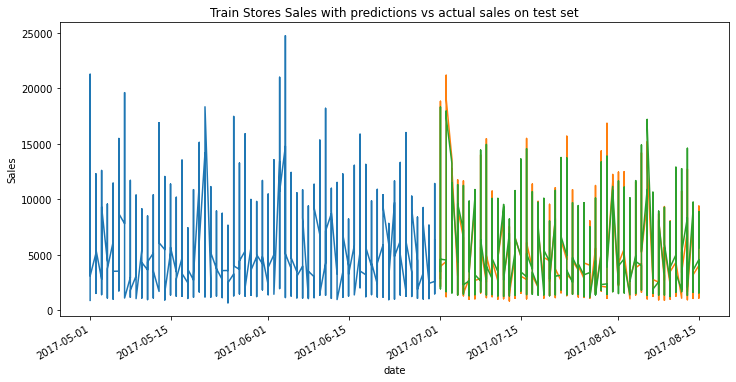

In [114]:
# look at predictions for books to sense check accuracy
train_family_mask = X_train['family'] == 'GROCERY I'
test_family_mask = X_test['family'] == 'GROCERY I'

plt.figure(figsize=(12,6))
y_train[train_family_mask].loc['2017-05-01':].plot()
y_test[test_family_mask].plot()
y_pred[test_family_mask].plot()

plt.title('Train Stores Sales with predictions vs actual sales on test set')
plt.ylabel('Sales')

plt.show()

### Check MSLE across stores and product familys to check for outliers

In [115]:
store_accuracy = np.zeros(len(store_nbrs))

for n, store in enumerate(store_nbrs):
    
    store_mask = X_test['store_nbr_'+str(store)] == 1
    
    msle = mean_squared_log_error(y_test[store_mask], y_pred[store_mask])
    
    store_accuracy[n] = msle

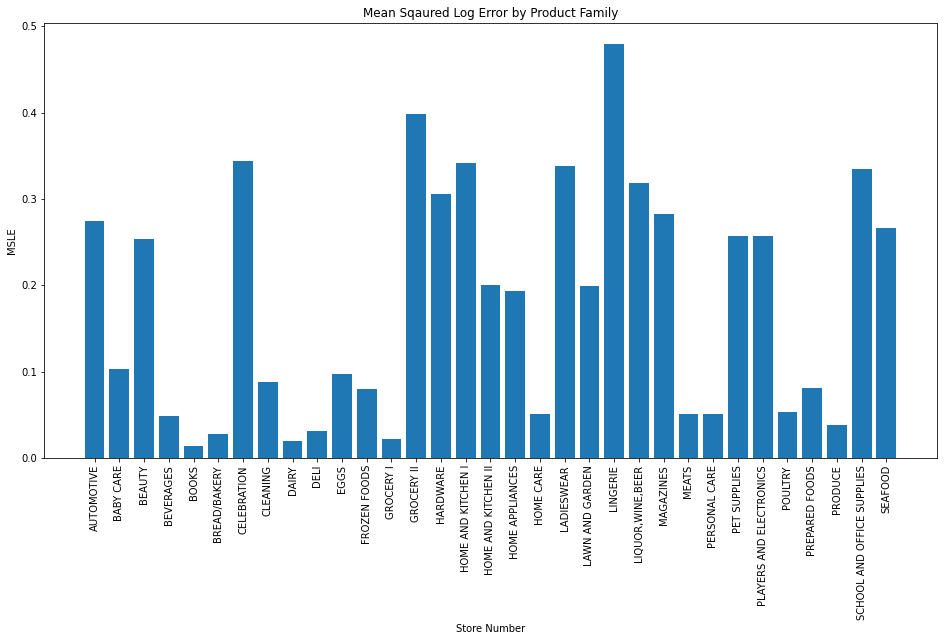

In [116]:
plt.figure(figsize=(16,8))

plt.bar(product_families,product_accuracy)

plt.xticks(rotation=90)

plt.xlabel('Store Number')
plt.ylabel('MSLE')

plt.title('Mean Sqaured Log Error by Product Family')
plt.show()

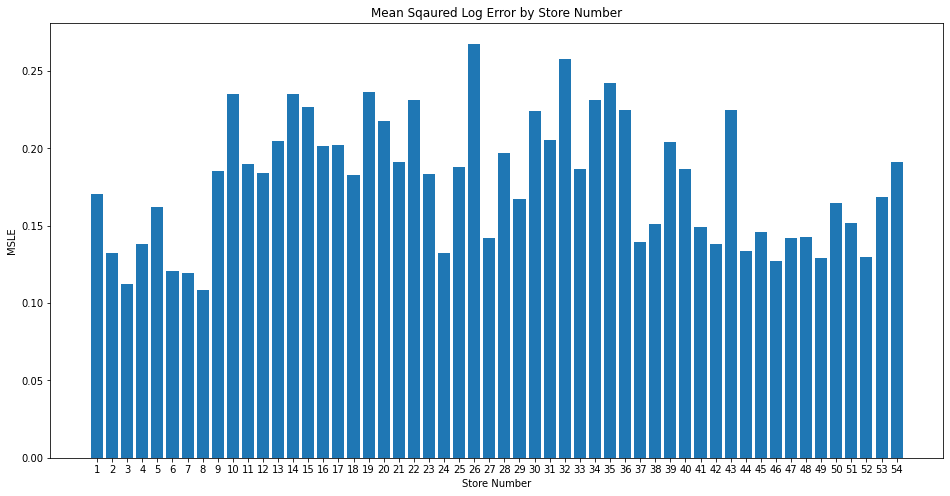

In [117]:
plt.figure(figsize=(16,8))

plt.bar(store_nbrs,store_accuracy)

plt.xticks(store_nbrs)

plt.xlabel('Store Number')
plt.ylabel('MSLE')

plt.title('Mean Sqaured Log Error by Store Number')
plt.show()

### Make Predictions

In [118]:
# functionable
y_submission_pred= pd.Series(data=0, index=X_submission.index)

for p_f in product_families:
    
    # train model
    model = family_models[p_f]    
    
    # make predictions
    submission_family_mask = X_submission['family'] == p_f
    
    y_submission_pred[submission_family_mask] = model.predict(X_submission[submission_family_mask].drop('family', axis=1))
        
    print(f'Made predictions of Family {p_f}')
    
y_submission_pred[y_submission_pred < 0] = 0
    

Made predictions of Family AUTOMOTIVE
Made predictions of Family BABY CARE
Made predictions of Family BEAUTY
Made predictions of Family BEVERAGES
Made predictions of Family BOOKS
Made predictions of Family BREAD/BAKERY
Made predictions of Family CELEBRATION
Made predictions of Family CLEANING
Made predictions of Family DAIRY
Made predictions of Family DELI
Made predictions of Family EGGS
Made predictions of Family FROZEN FOODS
Made predictions of Family GROCERY I
Made predictions of Family GROCERY II
Made predictions of Family HARDWARE
Made predictions of Family HOME AND KITCHEN I
Made predictions of Family HOME AND KITCHEN II
Made predictions of Family HOME APPLIANCES
Made predictions of Family HOME CARE
Made predictions of Family LADIESWEAR
Made predictions of Family LAWN AND GARDEN
Made predictions of Family LINGERIE
Made predictions of Family LIQUOR,WINE,BEER
Made predictions of Family MAGAZINES
Made predictions of Family MEATS
Made predictions of Family PERSONAL CARE
Made predicti

In [119]:
# Obtén las columnas directamente si solo tienes una columna en cada DataFrame
sales_column_y = y_submission_pred.squeeze()  # Accede directamente a la única columna
sales_column_X = X_submission_id.squeeze()    # Accede directamente a la única columna

# Crea un nuevo DataFrame con las columnas 'id' y 'sales'
new_df = pd.DataFrame({'id': sales_column_X.astype(int), 'sales': sales_column_y.astype(float)})

# Muestra el nuevo DataFrame
print(new_df)


                 id        sales
date                            
2017-08-16  3000888     4.933617
2017-08-16  3000889     0.048811
2017-08-16  3000890     4.637948
2017-08-16  3000891  2341.365960
2017-08-16  3000892     0.159816
...             ...          ...
2017-08-31  3029395   333.053313
2017-08-31  3029396   104.776100
2017-08-31  3029397  1136.106276
2017-08-31  3029398   127.493794
2017-08-31  3029399    14.799891

[28512 rows x 2 columns]


# Incluimos los valores de prediccion igual a 0

In [120]:
new_df.loc[new_df['id'].isin(id_zero),'sales']=0

In [121]:
new_df.to_csv('store_sales_submission_5.csv',index = False)